In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd

In [4]:
import bayesian_rainfall.model as brm

In [26]:
data = brm.load_data("data/noaa_historical_weather_eugene_or_2019-2024.csv")
data.head()

,DATE,PRCP,day_of_year
0,2019-01-01,0.0,1
1,2019-01-02,0.0,2
2,2019-01-03,0.0,3
3,2019-01-04,0.3,4
4,2019-01-05,4.6,5


In [27]:
model = brm.create_rainfall_model(data)
model

         a_rain ~ Normal(0, 2)
         b_rain ~ Normal(0, 2)
         c_rain ~ Normal(0, 1)
       a_amount ~ Normal(0, 2)
       b_amount ~ Normal(0, 2)
       c_amount ~ Normal(1, 1)
   alpha_amount ~ Gamma(2, f())
         p_rain ~ Deterministic(f(b_rain, c_rain, a_rain))
 rain_indicator ~ Bernoulli(p_rain)
rainfall_amount ~ Gamma(alpha_amount, f(alpha_amount, b_amount, c_amount, a_amount))

In [28]:
trace = brm.sample_model(model)
trace


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_rain, b_rain, c_rain, a_amount, b_amount, c_amount, alpha_amount]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [54]:
# Import plotting libraries
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

In [55]:
# Check convergence diagnostics
print("R-hat values (should be < 1.01 for good convergence):")
print(az.rhat(trace))
print("\nEffective sample size:")
print(az.ess(trace))


R-hat values (should be < 1.01 for good convergence):
<xarray.Dataset> Size: 35kB
Dimensions:       (p_rain_dim_0: 2192)
Coordinates:
  * p_rain_dim_0  (p_rain_dim_0) int64 18kB 0 1 2 3 4 ... 2188 2189 2190 2191
Data variables:
    a_rain        float64 8B 1.002
    b_rain        float64 8B 1.0
    c_rain        float64 8B 0.9995
    a_amount      float64 8B 1.0
    b_amount      float64 8B 0.9997
    c_amount      float64 8B 1.0
    alpha_amount  float64 8B 1.002
    p_rain        (p_rain_dim_0) float64 18kB 1.001 1.001 1.001 ... 1.001 1.0

Effective sample size:
<xarray.Dataset> Size: 35kB
Dimensions:       (p_rain_dim_0: 2192)
Coordinates:
  * p_rain_dim_0  (p_rain_dim_0) int64 18kB 0 1 2 3 4 ... 2188 2189 2190 2191
Data variables:
    a_rain        float64 8B 4.666e+03
    b_rain        float64 8B 4.956e+03
    c_rain        float64 8B 4.576e+03
    a_amount      float64 8B 3.673e+03
    b_amount      float64 8B 3.431e+03
    c_amount      float64 8B 3.395e+03
    alpha_amount  flo

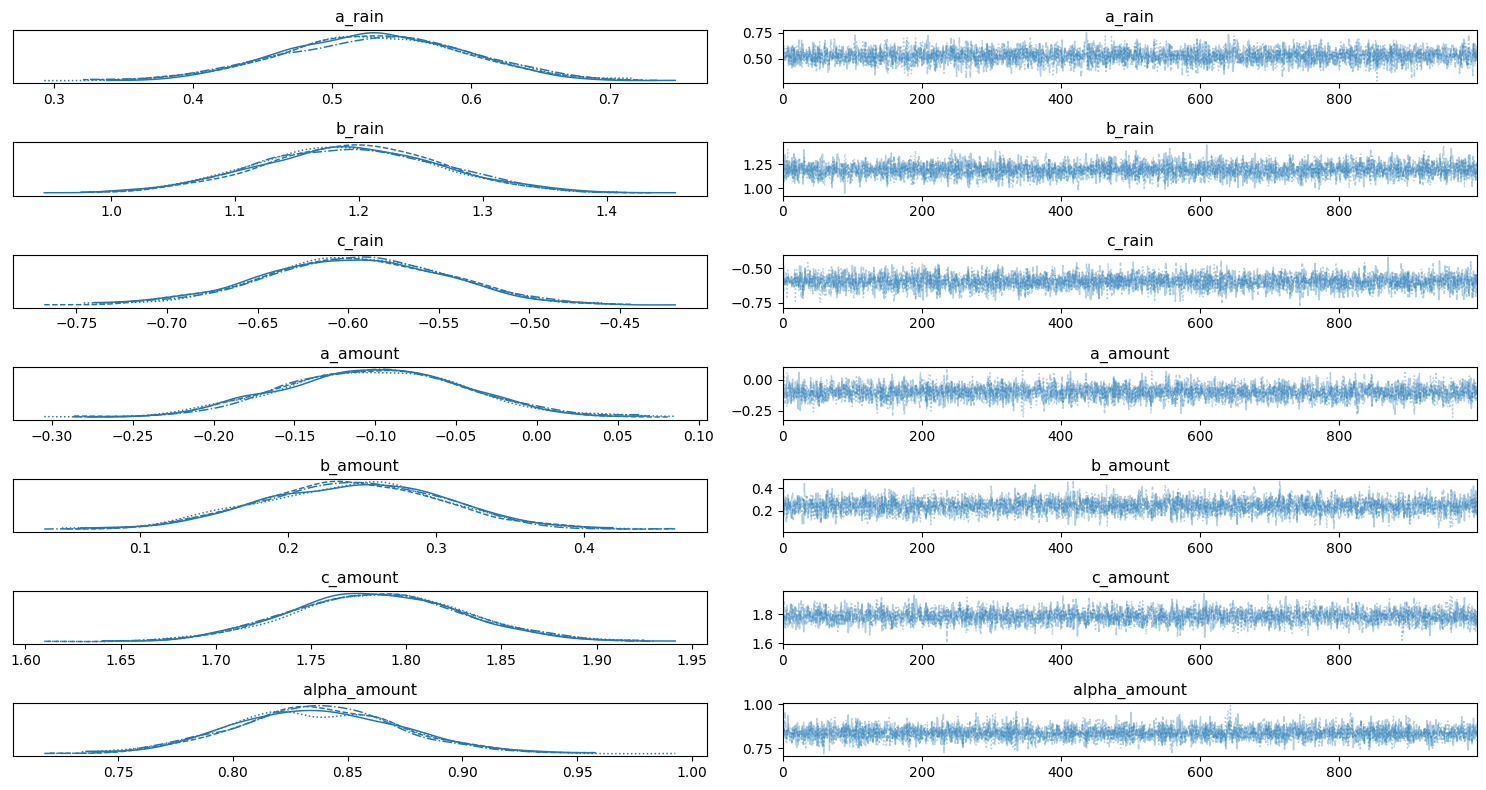

In [56]:
# Trace plots to check MCMC sampling
param_names = ['a_rain', 'b_rain', 'c_rain', 'a_amount', 'b_amount', 'c_amount', 'alpha_amount']

# Plot traces for main parameters
az.plot_trace(trace, var_names=param_names, figsize=(15, 8))
plt.tight_layout()
plt.show()


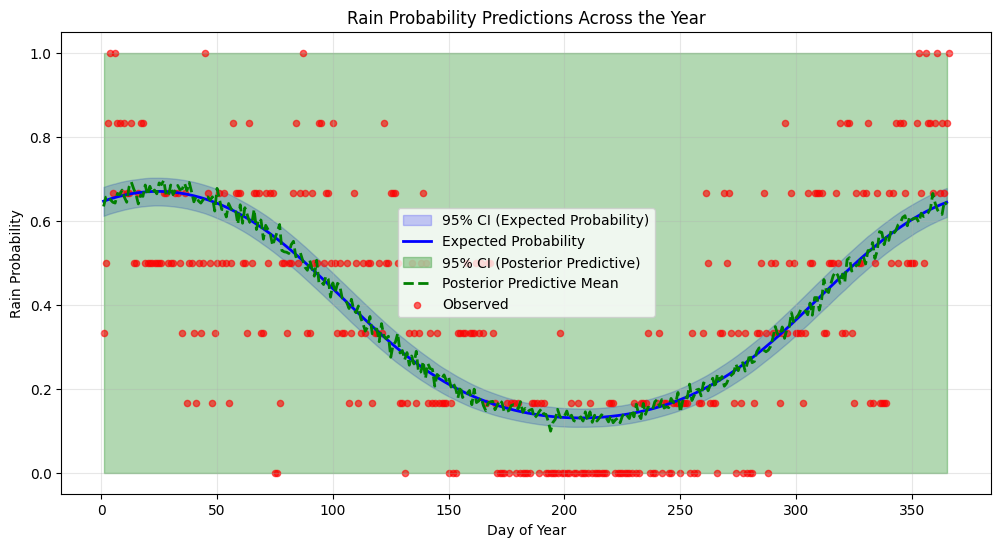

In [72]:
# Visualize rain probability predictions across the year

# Configurable credible interval (CI) level
ci_level = 0.95 # 80% CI by default; change as needed (e.g., 0.95 for 95%)
lower_percentile = 50 - (ci_level * 50)
upper_percentile = 50 + (ci_level * 50)

days_of_year = np.arange(1, 366)
day_sin_pred = np.sin(2 * np.pi * days_of_year / 365.25)
day_cos_pred = np.cos(2 * np.pi * days_of_year / 365.25)

# Get posterior samples for rain probability parameters
a_rain_samples = trace.posterior.a_rain.values.flatten()
b_rain_samples = trace.posterior.b_rain.values.flatten()
c_rain_samples = trace.posterior.c_rain.values.flatten()

# Calculate rain probabilities for each day
rain_probs = []
for i in range(len(a_rain_samples)):
    logit_p = c_rain_samples[i] + a_rain_samples[i] * day_sin_pred + b_rain_samples[i] * day_cos_pred
    p_rain = 1 / (1 + np.exp(-logit_p))  # sigmoid
    rain_probs.append(p_rain)

rain_probs = np.array(rain_probs)

# Calculate percentiles for the expected probabilities
rain_prob_mean = np.mean(rain_probs, axis=0)
rain_prob_lower = np.percentile(rain_probs, lower_percentile, axis=0)
rain_prob_upper = np.percentile(rain_probs, upper_percentile, axis=0)

# Generate posterior predictive samples for rain indicators
# This includes both parameter uncertainty AND observation uncertainty
n_samples = 1000
posterior_predictive_rain = []
for i in range(min(n_samples, len(a_rain_samples))):
    logit_p = c_rain_samples[i] + a_rain_samples[i] * day_sin_pred + b_rain_samples[i] * day_cos_pred
    p_rain = 1 / (1 + np.exp(-logit_p))
    # Sample actual rain indicators (this adds observation uncertainty)
    rain_indicators = np.random.binomial(1, p_rain)
    posterior_predictive_rain.append(rain_indicators)

posterior_predictive_rain = np.array(posterior_predictive_rain)

# Calculate percentiles for the posterior predictive
pp_rain_mean = np.mean(posterior_predictive_rain, axis=0)
pp_rain_lower = np.percentile(posterior_predictive_rain, lower_percentile, axis=0)
pp_rain_upper = np.percentile(posterior_predictive_rain, upper_percentile, axis=0)

# Plot
plt.figure(figsize=(12, 6))
# Plot the expected probability (parameter uncertainty only)
plt.fill_between(
    days_of_year, rain_prob_lower, rain_prob_upper, 
    alpha=0.2, color='blue', 
    label=f'{int(ci_level*100)}% CI (Expected Probability)'
)
plt.plot(days_of_year, rain_prob_mean, 'b-', linewidth=2, label='Expected Probability')

# Plot the posterior predictive (parameter + observation uncertainty)
plt.fill_between(
    days_of_year, pp_rain_lower, pp_rain_upper, 
    alpha=0.3, color='green', 
    label=f'{int(ci_level*100)}% CI (Posterior Predictive)'
)
plt.plot(days_of_year, pp_rain_mean, 'g--', linewidth=2, label='Posterior Predictive Mean')

# Add observed data for comparison
observed_rain_prob = data.groupby('day_of_year')['PRCP'].apply(lambda x: (x > 0).mean()).values
observed_days = data.groupby('day_of_year')['PRCP'].apply(lambda x: (x > 0).mean()).index.values
plt.scatter(observed_days, observed_rain_prob, alpha=0.6, color='red', s=20, label='Observed')

plt.xlabel('Day of Year')
plt.ylabel('Rain Probability')
plt.title('Rain Probability Predictions Across the Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


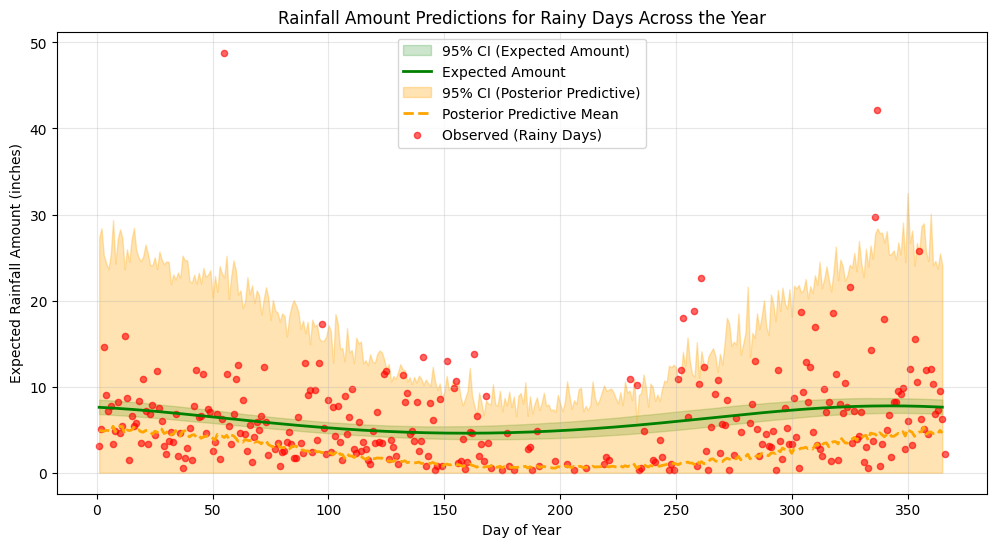

In [73]:
# Visualize rainfall amount predictions for rainy days
# Get posterior samples for rainfall amount parameters
a_amount_samples = trace.posterior.a_amount.values.flatten()
b_amount_samples = trace.posterior.b_amount.values.flatten()
c_amount_samples = trace.posterior.c_amount.values.flatten()
alpha_amount_samples = trace.posterior.alpha_amount.values.flatten()

# Calculate expected rainfall amounts for each day
rainfall_amounts = []
for i in range(len(a_amount_samples)):
    mu_amount = np.exp(c_amount_samples[i] + a_amount_samples[i] * day_sin_pred + b_amount_samples[i] * day_cos_pred)
    rainfall_amounts.append(mu_amount)

rainfall_amounts = np.array(rainfall_amounts)

# Calculate percentiles for expected amounts
rainfall_mean = np.mean(rainfall_amounts, axis=0)
rainfall_lower = np.percentile(rainfall_amounts, 2.5, axis=0)
rainfall_upper = np.percentile(rainfall_amounts, 97.5, axis=0)

# Generate posterior predictive samples for rainfall amounts
# This includes both parameter uncertainty AND observation uncertainty
posterior_predictive_amounts = []
for i in range(min(n_samples, len(a_amount_samples))):
    # First sample whether it rains
    logit_p = c_rain_samples[i] + a_rain_samples[i] * day_sin_pred + b_rain_samples[i] * day_cos_pred
    p_rain = 1 / (1 + np.exp(-logit_p))
    rain_indicators = np.random.binomial(1, p_rain)
    
    # Then sample rainfall amounts for rainy days
    mu_amount = np.exp(c_amount_samples[i] + a_amount_samples[i] * day_sin_pred + b_amount_samples[i] * day_cos_pred)
    rainfall = np.zeros(len(days_of_year))
    rainy_mask = rain_indicators == 1
    if np.sum(rainy_mask) > 0:
        rainfall[rainy_mask] = np.random.gamma(alpha_amount_samples[i], mu_amount[rainy_mask] / alpha_amount_samples[i])
    
    posterior_predictive_amounts.append(rainfall)

posterior_predictive_amounts = np.array(posterior_predictive_amounts)

# Calculate percentiles for posterior predictive amounts
pp_amounts_mean = np.mean(posterior_predictive_amounts, axis=0)
pp_amounts_lower = np.percentile(posterior_predictive_amounts, 2.5, axis=0)
pp_amounts_upper = np.percentile(posterior_predictive_amounts, 97.5, axis=0)

# Plot
plt.figure(figsize=(12, 6))
# Plot the expected amounts (parameter uncertainty only)
plt.fill_between(days_of_year, rainfall_lower, rainfall_upper, alpha=0.2, color='green', label='95% CI (Expected Amount)')
plt.plot(days_of_year, rainfall_mean, 'g-', linewidth=2, label='Expected Amount')

# Plot the posterior predictive (parameter + observation uncertainty)
plt.fill_between(days_of_year, pp_amounts_lower, pp_amounts_upper, alpha=0.3, color='orange', label='95% CI (Posterior Predictive)')
plt.plot(days_of_year, pp_amounts_mean, 'orange', linestyle='--', linewidth=2, label='Posterior Predictive Mean')

# Add observed data for comparison (only rainy days)
rainy_data = data[data['PRCP'] > 0]
observed_rainfall = rainy_data.groupby('day_of_year')['PRCP'].mean().values
observed_rainy_days = rainy_data.groupby('day_of_year')['PRCP'].mean().index.values
plt.scatter(observed_rainy_days, observed_rainfall, alpha=0.6, color='red', s=20, label='Observed (Rainy Days)')

plt.xlabel('Day of Year')
plt.ylabel('Expected Rainfall Amount (inches)')
plt.title('Rainfall Amount Predictions for Rainy Days Across the Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [60]:
# Visualize rainfall amount predictions for rainy days
# Get posterior samples for rainfall amount parameters
a_amount_samples = trace.posterior.a_amount.values.flatten()
b_amount_samples = trace.posterior.b_amount.values.flatten()
c_amount_samples = trace.posterior.c_amount.values.flatten()
alpha_amount_samples = trace.posterior.alpha_amount.values.flatten()

# Calculate expected rainfall amounts for each day
rainfall_amounts = []
for i in range(len(a_amount_samples)):
    mu_amount = np.exp(c_amount_samples[i] + a_amount_samples[i] * day_sin_pred + b_amount_samples[i] * day_cos_pred)
    rainfall_amounts.append(mu_amount)

rainfall_amounts = np.array(rainfall_amounts)

# Calculate percentiles
rainfall_mean = np.mean(rainfall_amounts, axis=0)
rainfall_lower = np.percentile(rainfall_amounts, 2.5, axis=0)
rainfall_upper = np.percentile(rainfall_amounts, 97.5, axis=0)

# Add observed data for comparison (only rainy days)
rainy_data = data[data['PRCP'] > 0]
observed_rainfall = rainy_data.groupby('day_of_year')['PRCP'].mean().values
observed_rainy_days = rainy_data.groupby('day_of_year')['PRCP'].mean().index.values

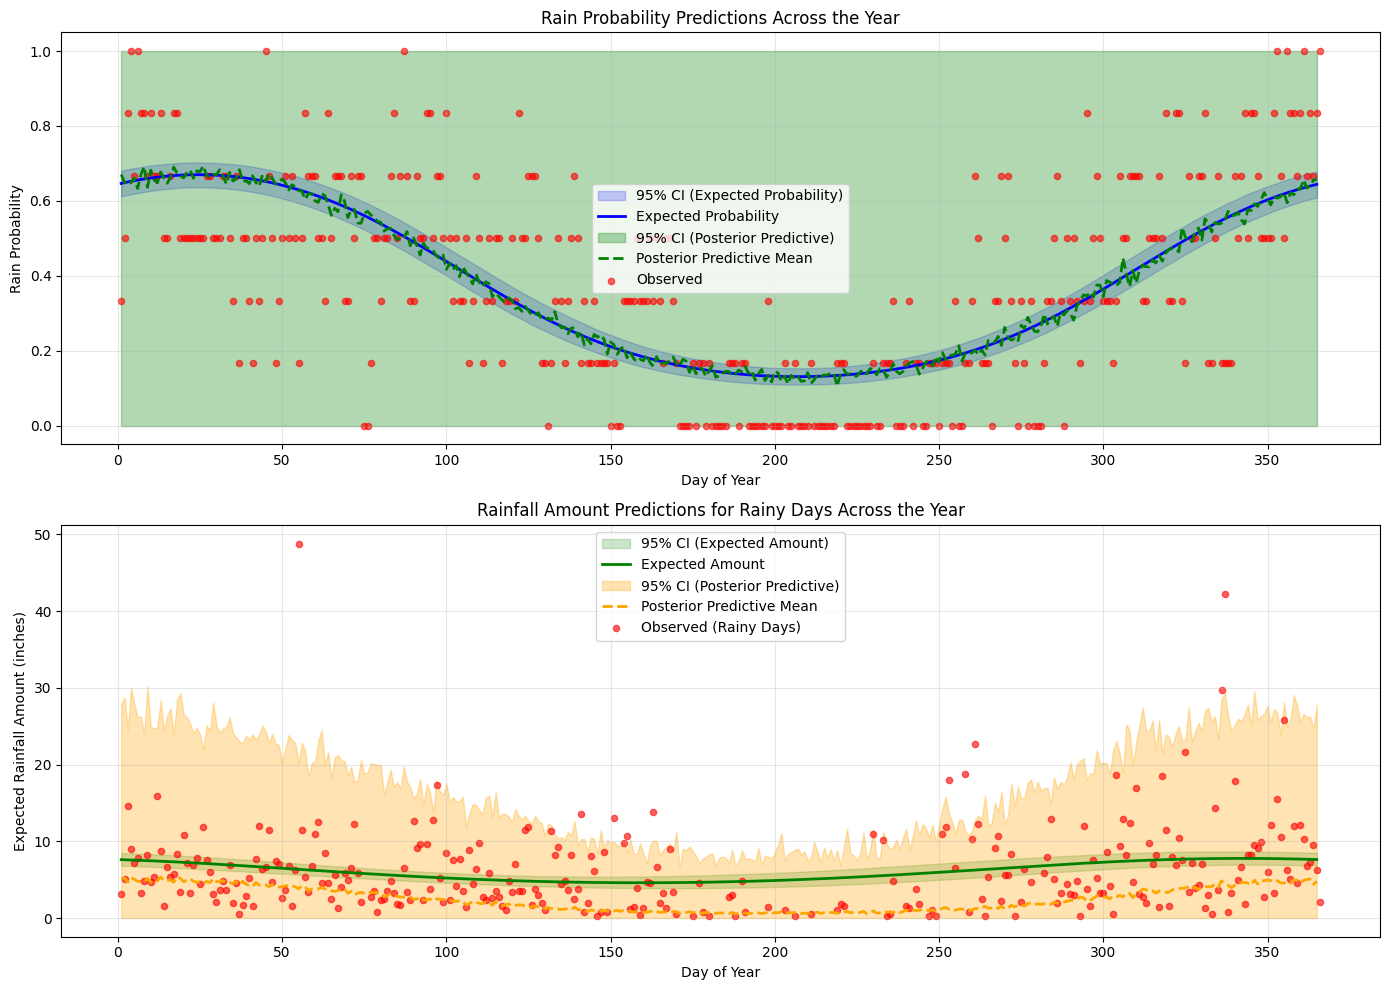

In [61]:
# Updated Combined visualization: Rain probability and amount predictions with both CIs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Rain probability plot
ax1.fill_between(days_of_year, rain_prob_lower, rain_prob_upper, alpha=0.2, color='blue', label='95% CI (Expected Probability)')
ax1.plot(days_of_year, rain_prob_mean, 'b-', linewidth=2, label='Expected Probability')
ax1.fill_between(days_of_year, pp_rain_lower, pp_rain_upper, alpha=0.3, color='green', label='95% CI (Posterior Predictive)')
ax1.plot(days_of_year, pp_rain_mean, 'g--', linewidth=2, label='Posterior Predictive Mean')
ax1.scatter(observed_days, observed_rain_prob, alpha=0.6, color='red', s=20, label='Observed')
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('Rain Probability')
ax1.set_title('Rain Probability Predictions Across the Year')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rainfall amount plot
ax2.fill_between(days_of_year, rainfall_lower, rainfall_upper, alpha=0.2, color='green', label='95% CI (Expected Amount)')
ax2.plot(days_of_year, rainfall_mean, 'g-', linewidth=2, label='Expected Amount')
ax2.fill_between(days_of_year, pp_amounts_lower, pp_amounts_upper, alpha=0.3, color='orange', label='95% CI (Posterior Predictive)')
ax2.plot(days_of_year, pp_amounts_mean, 'orange', linestyle='--', linewidth=2, label='Posterior Predictive Mean')
ax2.scatter(observed_rainy_days, observed_rainfall, alpha=0.6, color='red', s=20, label='Observed (Rainy Days)')
ax2.set_xlabel('Day of Year')
ax2.set_ylabel('Expected Rainfall Amount (inches)')
ax2.set_title('Rainfall Amount Predictions for Rainy Days Across the Year')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Sampling: [rain_indicator]


Output()

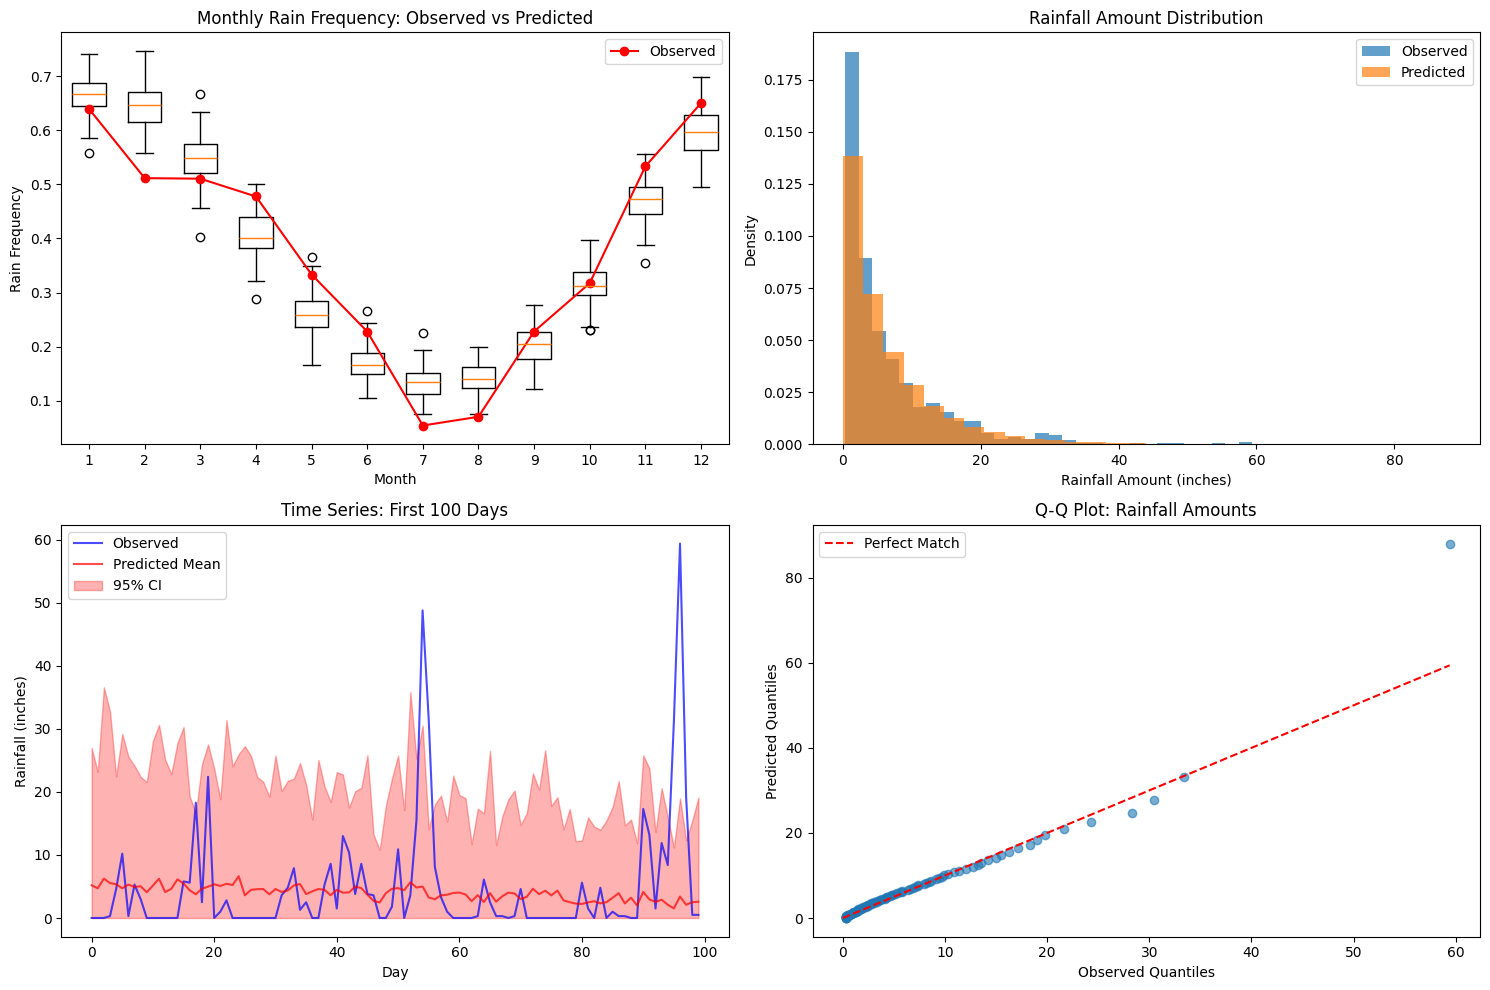

In [62]:
# Posterior predictive checks
# Generate posterior predictive samples for rain indicator only
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['rain_indicator'])

# Extract rain indicator predictions
predicted_rain_indicator = posterior_predictive.posterior_predictive.rain_indicator.values

# Generate full rainfall predictions by sampling from the model
full_rainfall_predictions = []
n_samples = 100  # Number of posterior samples to use

for i in range(min(n_samples, predicted_rain_indicator.shape[0] * predicted_rain_indicator.shape[1])):
    # Get sample index
    chain_idx = i // predicted_rain_indicator.shape[1]
    sample_idx = i % predicted_rain_indicator.shape[1]
    
    # Get parameters for this sample
    a_rain = trace.posterior.a_rain.values[chain_idx, sample_idx]
    b_rain = trace.posterior.b_rain.values[chain_idx, sample_idx]
    c_rain = trace.posterior.c_rain.values[chain_idx, sample_idx]
    a_amount = trace.posterior.a_amount.values[chain_idx, sample_idx]
    b_amount = trace.posterior.b_amount.values[chain_idx, sample_idx]
    c_amount = trace.posterior.c_amount.values[chain_idx, sample_idx]
    alpha_amount = trace.posterior.alpha_amount.values[chain_idx, sample_idx]
    
    # Calculate rain probabilities
    day_of_year = data['day_of_year'].values
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)
    
    logit_p = c_rain + a_rain * day_sin + b_rain * day_cos
    p_rain = 1 / (1 + np.exp(-logit_p))
    
    # Sample rain indicators
    rain_indicator = np.random.binomial(1, p_rain)
    
    # Calculate expected rainfall amounts
    mu_amount = np.exp(c_amount + a_amount * day_sin + b_amount * day_cos)
    
    # Sample rainfall amounts for rainy days
    rainfall = np.zeros(len(day_of_year))
    rainy_mask = rain_indicator == 1
    if np.sum(rainy_mask) > 0:
        rainfall[rainy_mask] = np.random.gamma(alpha_amount, mu_amount[rainy_mask] / alpha_amount)
    
    full_rainfall_predictions.append(rainfall)

full_rainfall_predictions = np.array(full_rainfall_predictions)

# Plot posterior predictive checks
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rain frequency by month
data['month'] = pd.to_datetime(data['DATE']).dt.month
monthly_rain_freq_obs = data.groupby('month')['PRCP'].apply(lambda x: (x > 0).mean())
monthly_rain_freq_pred = []
for month in range(1, 13):
    month_data = data[data['month'] == month]
    if len(month_data) > 0:
        month_indices = month_data.index - data.index[0]  # Convert to 0-based index
        month_predictions = full_rainfall_predictions[:, month_indices]
        month_rain_freq = np.mean(month_predictions > 0, axis=1)
        monthly_rain_freq_pred.append(month_rain_freq)

monthly_rain_freq_pred = np.array(monthly_rain_freq_pred).T

axes[0, 0].boxplot(monthly_rain_freq_pred, positions=range(1, 13), widths=0.6)
axes[0, 0].plot(range(1, 13), monthly_rain_freq_obs, 'ro-', label='Observed')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Rain Frequency')
axes[0, 0].set_title('Monthly Rain Frequency: Observed vs Predicted')
axes[0, 0].legend()

# 2. Rainfall amount distribution
rainy_obs = data[data['PRCP'] > 0]['PRCP'].values
rainy_pred = full_rainfall_predictions[full_rainfall_predictions > 0].flatten()

axes[0, 1].hist(rainy_obs, bins=30, alpha=0.7, label='Observed', density=True)
axes[0, 1].hist(rainy_pred, bins=30, alpha=0.7, label='Predicted', density=True)
axes[0, 1].set_xlabel('Rainfall Amount (inches)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Rainfall Amount Distribution')
axes[0, 1].legend()

# 3. Time series comparison (first 100 days)
first_100_days = data.head(100)
first_100_pred = full_rainfall_predictions[:, :100]

axes[1, 0].plot(first_100_days['PRCP'].values, 'b-', label='Observed', alpha=0.7)
axes[1, 0].plot(np.mean(first_100_pred, axis=0), 'r-', label='Predicted Mean', alpha=0.7)
axes[1, 0].fill_between(range(100), 
                       np.percentile(first_100_pred, 2.5, axis=0),
                       np.percentile(first_100_pred, 97.5, axis=0),
                       alpha=0.3, color='red', label='95% CI')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Rainfall (inches)')
axes[1, 0].set_title('Time Series: First 100 Days')
axes[1, 0].legend()

# 4. Q-Q plot for rainfall amounts
from scipy import stats
obs_quantiles = np.percentile(rainy_obs, np.linspace(0, 100, 100))
pred_quantiles = np.percentile(rainy_pred, np.linspace(0, 100, 100))

axes[1, 1].scatter(obs_quantiles, pred_quantiles, alpha=0.6)
axes[1, 1].plot([0, max(obs_quantiles)], [0, max(obs_quantiles)], 'r--', label='Perfect Match')
axes[1, 1].set_xlabel('Observed Quantiles')
axes[1, 1].set_ylabel('Predicted Quantiles')
axes[1, 1].set_title('Q-Q Plot: Rainfall Amounts')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


In [63]:
# Summary statistics and model evaluation
print("=== MODEL SUMMARY ===")
print(f"Total observations: {len(data)}")
print(f"Rainy days: {len(data[data['PRCP'] > 0])}")
print(f"Overall rain frequency: {len(data[data['PRCP'] > 0]) / len(data):.3f}")
print(f"Mean rainfall on rainy days: {data[data['PRCP'] > 0]['PRCP'].mean():.3f} inches")
print(f"Max rainfall: {data['PRCP'].max():.3f} inches")

print("\n=== CONVERGENCE DIAGNOSTICS ===")
print("R-hat values (should be < 1.01):")
for param in param_names:
    rhat = az.rhat(trace, var_names=[param])[param].values
    print(f"  {param}: {rhat:.4f}")

print("\n=== SEASONAL PATTERNS ===")
# Find peak and minimum rain probability days
peak_day = days_of_year[np.argmax(rain_prob_mean)]
min_day = days_of_year[np.argmin(rain_prob_mean)]
print(f"Peak rain probability: Day {peak_day} ({rain_prob_mean[np.argmax(rain_prob_mean)]:.3f})")
print(f"Minimum rain probability: Day {min_day} ({rain_prob_mean[np.argmin(rain_prob_mean)]:.3f})")

# Find peak and minimum rainfall amounts
peak_amount_day = days_of_year[np.argmax(rainfall_mean)]
min_amount_day = days_of_year[np.argmin(rainfall_mean)]
print(f"Peak rainfall amount: Day {peak_amount_day} ({rainfall_mean[np.argmax(rainfall_mean)]:.3f} inches)")
print(f"Minimum rainfall amount: Day {min_amount_day} ({rainfall_mean[np.argmin(rainfall_mean)]:.3f} inches)")


=== MODEL SUMMARY ===
Total observations: 2192
Rainy days: 830
Overall rain frequency: 0.379
Mean rainfall on rainy days: 6.465 inches
Max rainfall: 59.400 inches

=== CONVERGENCE DIAGNOSTICS ===
R-hat values (should be < 1.01):
  a_rain: 1.0016
  b_rain: 1.0005
  c_rain: 0.9995
  a_amount: 1.0004
  b_amount: 0.9997
  c_amount: 1.0005
  alpha_amount: 1.0021

=== SEASONAL PATTERNS ===
Peak rain probability: Day 24 (0.670)
Minimum rain probability: Day 207 (0.130)
Peak rainfall amount: Day 342 (7.769 inches)
Minimum rainfall amount: Day 159 (4.593 inches)


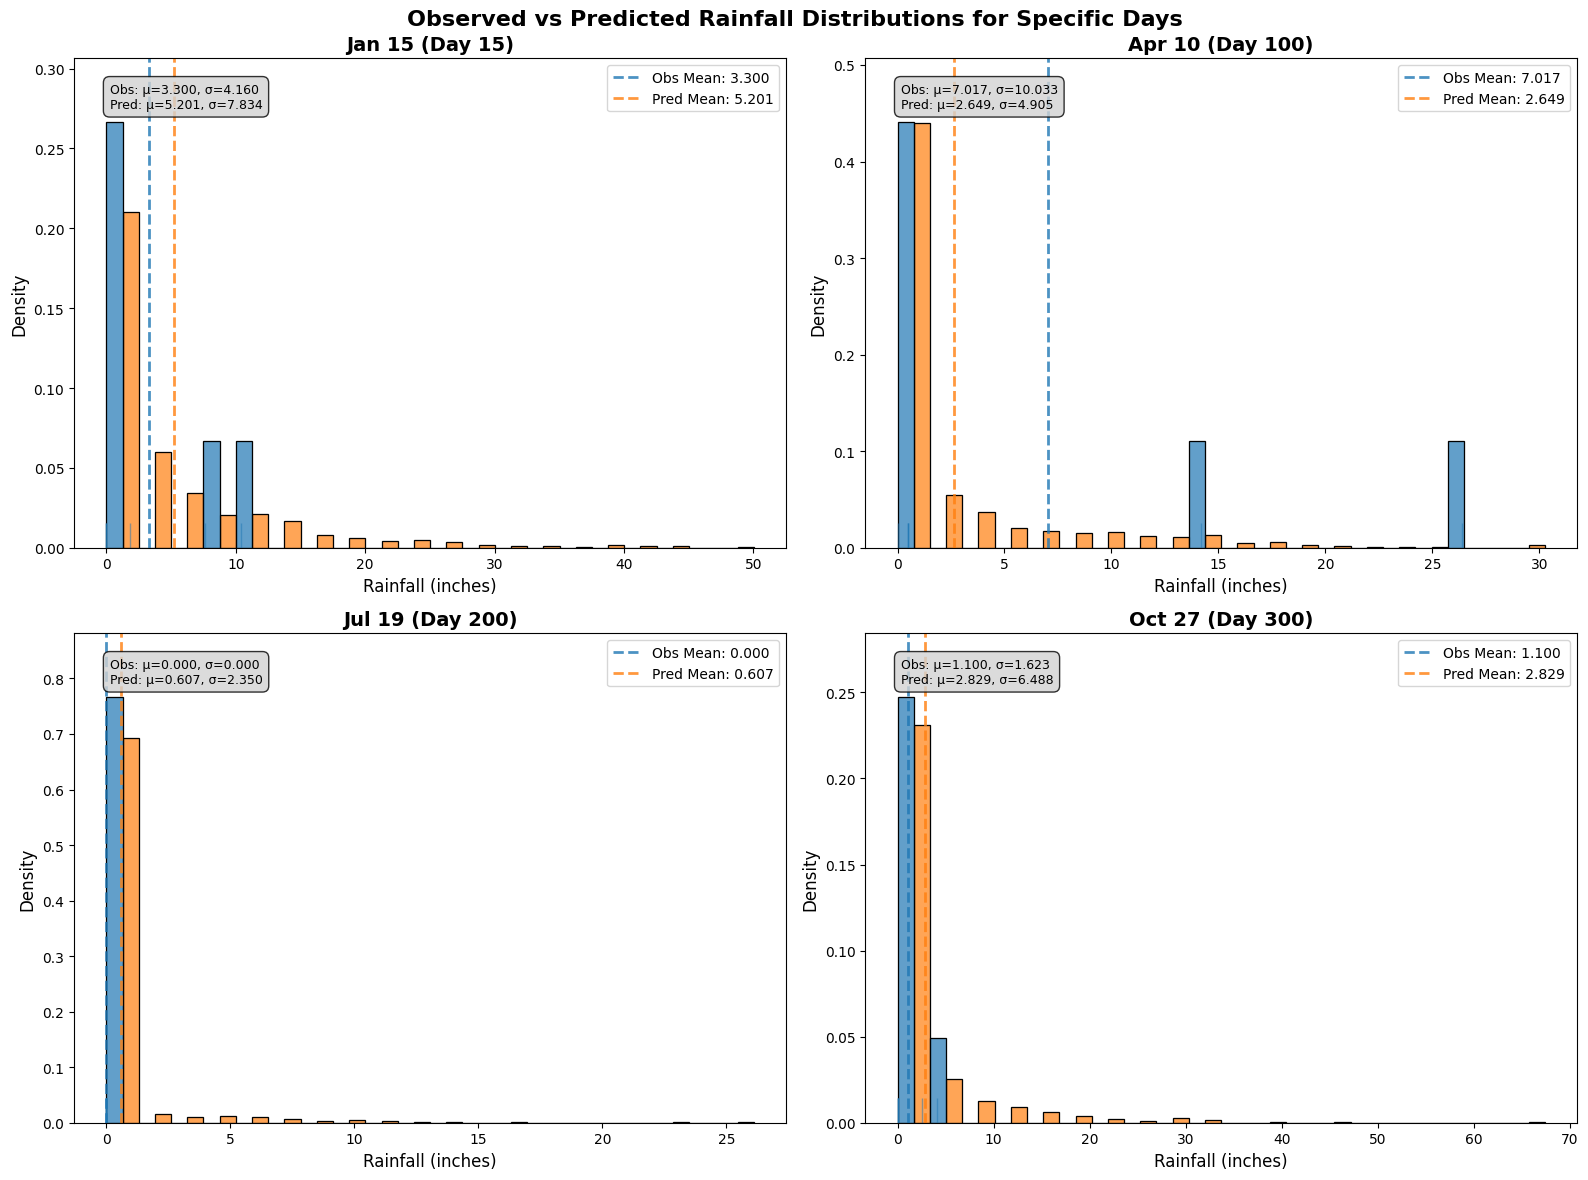

In [89]:
# Plot observed vs predicted rainfall distributions for specific days using histograms and rug plots
# Select a few representative days throughout the year
selected_days = [15, 100, 200, 300]  # January 15, April 10, July 19, October 27
day_names = ['Jan 15', 'Apr 10', 'Jul 19', 'Oct 27']

# Create a figure with seaborn styling
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (day, day_name) in enumerate(zip(selected_days, day_names)):
    # Get observed data for this day of year across all years
    day_data = data[data['day_of_year'] == day]['PRCP'].values
    
    # Get predicted data for this day of year
    day_predictions = full_rainfall_predictions[:, data['day_of_year'] == day]
    if day_predictions.size > 0:
        day_predictions = day_predictions.flatten()
    else:
        # If no data for this exact day, use nearby days
        nearby_days = data[(data['day_of_year'] >= day-2) & (data['day_of_year'] <= day+2)]
        if len(nearby_days) > 0:
            day_data = nearby_days['PRCP'].values
            # For predictions, we'll use the model predictions for this day
            day_sin = np.sin(2 * np.pi * day / 365.25)
            day_cos = np.cos(2 * np.pi * day / 365.25)
            
            # Sample predictions for this specific day
            day_predictions = []
            for j in range(min(100, len(trace.posterior.a_rain.values.flatten()))):
                chain_idx = j // trace.posterior.a_rain.shape[1]
                sample_idx = j % trace.posterior.a_rain.shape[1]
                
                a_rain = trace.posterior.a_rain.values[chain_idx, sample_idx]
                b_rain = trace.posterior.b_rain.values[chain_idx, sample_idx]
                c_rain = trace.posterior.c_rain.values[chain_idx, sample_idx]
                a_amount = trace.posterior.a_amount.values[chain_idx, sample_idx]
                b_amount = trace.posterior.b_amount.values[chain_idx, sample_idx]
                c_amount = trace.posterior.c_amount.values[chain_idx, sample_idx]
                alpha_amount = trace.posterior.alpha_amount.values[chain_idx, sample_idx]
                
                # Calculate rain probability
                logit_p = c_rain + a_rain * day_sin + b_rain * day_cos
                p_rain = 1 / (1 + np.exp(-logit_p))
                
                # Sample rain indicator
                rain_indicator = np.random.binomial(1, p_rain)
                
                # Sample rainfall amount if it rains
                if rain_indicator == 1:
                    mu_amount = np.exp(c_amount + a_amount * day_sin + b_amount * day_cos)
                    rainfall = np.random.gamma(alpha_amount, mu_amount / alpha_amount)
                else:
                    rainfall = 0
                
                day_predictions.append(rainfall)
            
            day_predictions = np.array(day_predictions)
    
    # Create data for seaborn
    obs_df = pd.DataFrame({'Rainfall': day_data, 'Type': 'Observed'})
    pred_df = pd.DataFrame({'Rainfall': day_predictions, 'Type': 'Predicted'})
    combined_df = pd.concat([obs_df, pred_df], ignore_index=True)
    
    # Plot grouped histograms with seaborn (no KDE) - use common bins for fair comparison
    sns.histplot(data=combined_df, x='Rainfall', hue='Type', 
                alpha=0.7, ax=axes[i], bins=20, stat='density', common_norm=False, 
                multiple='dodge')
    
    # Add rug plot for observed data
    sns.rugplot(data=obs_df, x='Rainfall', ax=axes[i], color='#1f77b4', alpha=0.5, height=0.05)
    
    # Add statistics
    obs_mean = np.mean(day_data)
    pred_mean = np.mean(day_predictions)
    obs_std = np.std(day_data)
    pred_std = np.std(day_predictions)
    
    # Add mean lines with seaborn styling
    axes[i].axvline(obs_mean, color='#1f77b4', linestyle='--', alpha=0.8, linewidth=2, 
                   label=f'Obs Mean: {obs_mean:.3f}')
    axes[i].axvline(pred_mean, color='#ff7f0e', linestyle='--', alpha=0.8, linewidth=2, 
                   label=f'Pred Mean: {pred_mean:.3f}')
    
    axes[i].set_title(f'{day_name} (Day {day})', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Rainfall (inches)', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=10)
    
    # Add text box with statistics using seaborn styling
    textstr = f'Obs: μ={obs_mean:.3f}, σ={obs_std:.3f}\nPred: μ={pred_mean:.3f}, σ={pred_std:.3f}'
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                facecolor='lightgray', alpha=0.8))

plt.suptitle('Observed vs Predicted Rainfall Distributions for Specific Days', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


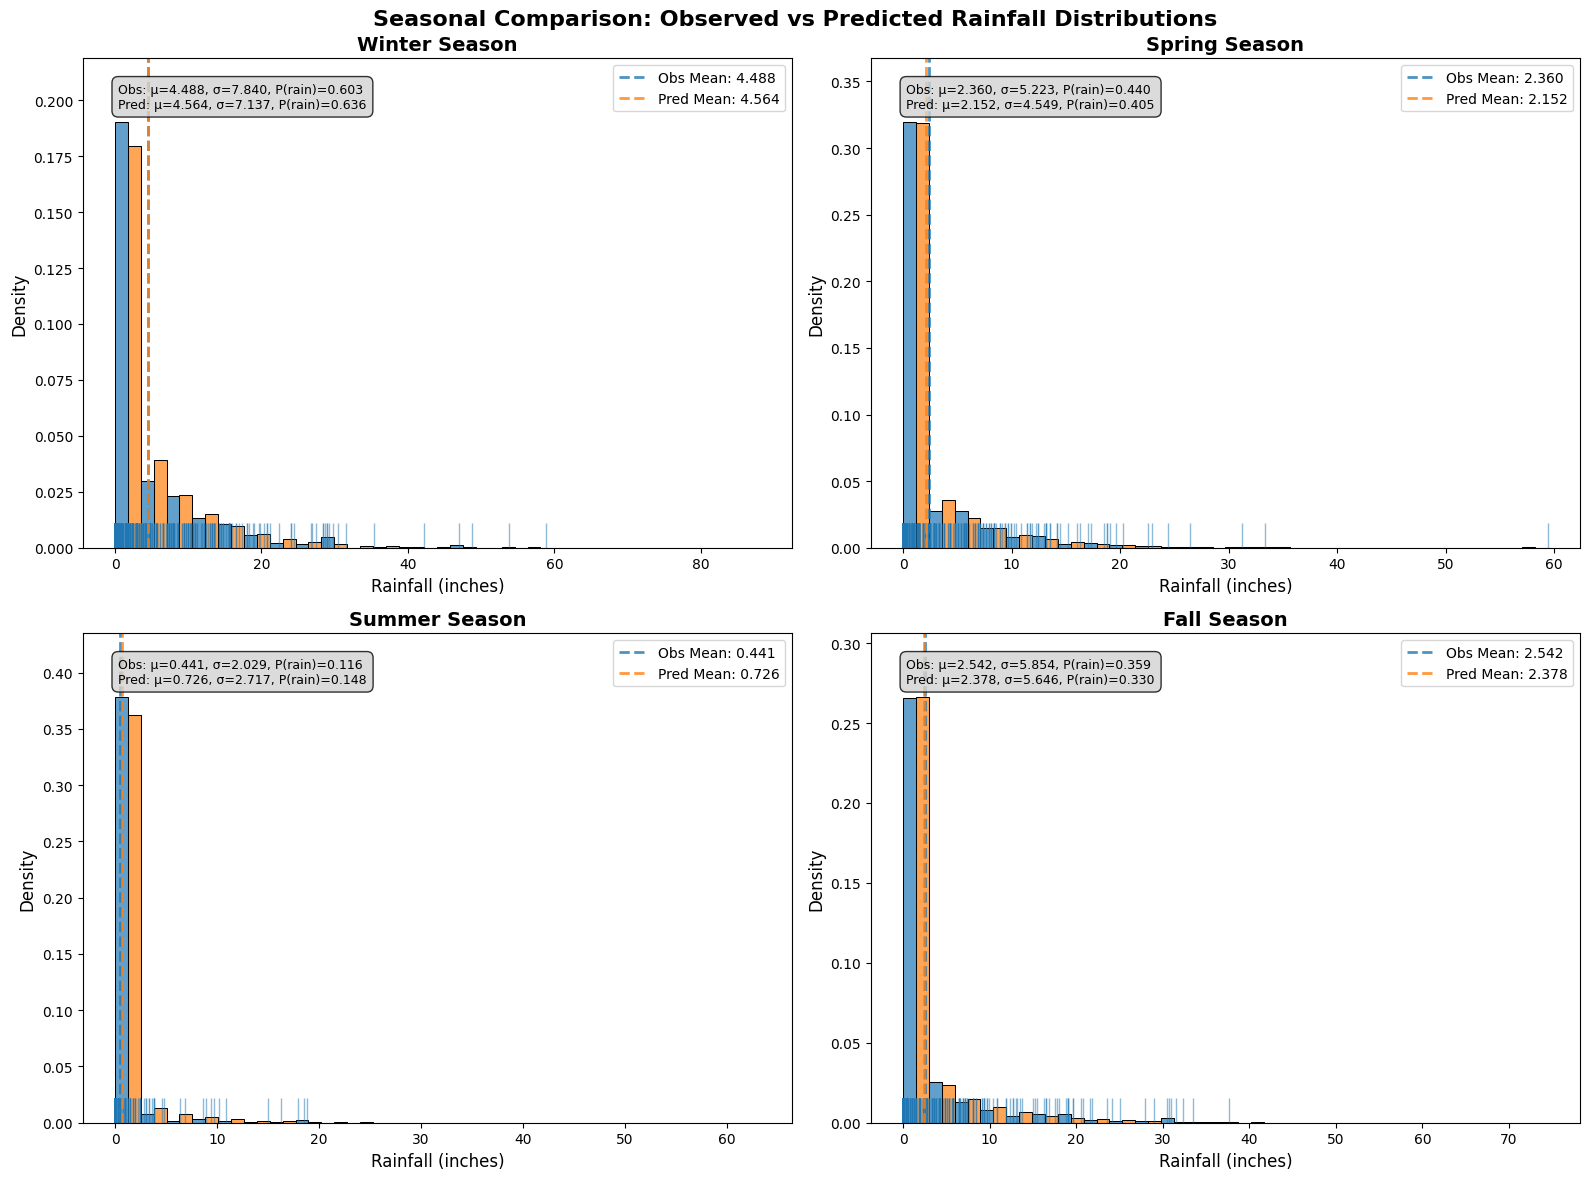

In [92]:
# Seasonal comparison: Observed vs Predicted distributions by season using histograms and rug plots
# Define seasons
seasons = {
    'Winter': [1, 2, 12],  # Dec, Jan, Feb
    'Spring': [3, 4, 5],   # Mar, Apr, May
    'Summer': [6, 7, 8],   # Jun, Jul, Aug
    'Fall': [9, 10, 11]    # Sep, Oct, Nov
}

# Create a figure with seaborn styling
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (season_name, months) in enumerate(seasons.items()):
    # Get observed data for this season
    season_data = data[data['month'].isin(months)]['PRCP'].values
    
    # Get predicted data for this season
    season_mask = data['month'].isin(months)
    season_predictions = full_rainfall_predictions[:, season_mask]
    season_predictions = season_predictions.flatten()
    
    # Create data for seaborn
    obs_df = pd.DataFrame({'Rainfall': season_data, 'Type': 'Observed'})
    pred_df = pd.DataFrame({'Rainfall': season_predictions, 'Type': 'Predicted'})
    combined_df = pd.concat([obs_df, pred_df], ignore_index=True)
    
    # Plot grouped histograms with seaborn (no KDE)
    sns.histplot(data=combined_df, x='Rainfall', hue='Type', 
                alpha=0.7, ax=axes[i], bins=25, stat='density', 
                multiple='dodge', common_norm=False)
    
    # Add rug plot for observed data
    sns.rugplot(data=obs_df, x='Rainfall', ax=axes[i], color='#1f77b4', alpha=0.5, height=0.05)
    
    # Add statistics
    obs_mean = np.mean(season_data)
    pred_mean = np.mean(season_predictions)
    obs_std = np.std(season_data)
    pred_std = np.std(season_predictions)
    
    # Calculate rain frequency
    obs_rain_freq = np.mean(season_data > 0)
    pred_rain_freq = np.mean(season_predictions > 0)
    
    # Add mean lines with seaborn styling
    axes[i].axvline(obs_mean, color='#1f77b4', linestyle='--', alpha=0.8, linewidth=2, 
                   label=f'Obs Mean: {obs_mean:.3f}')
    axes[i].axvline(pred_mean, color='#ff7f0e', linestyle='--', alpha=0.8, linewidth=2, 
                   label=f'Pred Mean: {pred_mean:.3f}')
    
    axes[i].set_title(f'{season_name} Season', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Rainfall (inches)', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=10)
    
    # Add text box with statistics using seaborn styling
    textstr = f'Obs: μ={obs_mean:.3f}, σ={obs_std:.3f}, P(rain)={obs_rain_freq:.3f}\nPred: μ={pred_mean:.3f}, σ={pred_std:.3f}, P(rain)={pred_rain_freq:.3f}'
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                facecolor='lightgray', alpha=0.8))

plt.suptitle('Seasonal Comparison: Observed vs Predicted Rainfall Distributions', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()
